Modele autoregressif vectoriel après désaisonnalisation avec un GAM et 10 noeuds

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import GammaRegressor

from statsmodels.tsa.api import VAR

In [3]:
def fct_scores_mse(Y_true, Y_pred, liste_stations):
    
    Y_true = Y_true.sort_values(by = ["Date"])
    Y_pred = Y_pred.sort_values(by = ["Date"])
    
    liste_mse = []
    for code in liste_stations:
        liste_mse.append(np.mean(np.square(Y_true[code].values - Y_pred[code].values)))
    resultat = pd.DataFrame({"Code station": liste_stations, "MSE": liste_mse})
    return resultat

In [4]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base_journalier/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base_journalier/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base_journalier/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base_journalier/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base_journalier/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base_journalier/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

# Fonctions

## Saisonnalité

In [5]:
def fct_Modele_SplineGamma_fit(mesures_train, liste_stations, n_knots):
    ## Fonction pour déterminer les splines cycliques, GAM gamma
    # mesures: dataframe X d'entrainement
    # n_knots: le nombre de noeuds
    
    mesures_stations = mesures_train[["Date"] + liste_stations]
    # On prend en abscisse le delta de temps par rapport au 01/01 de l'année en cours
    mesures_tofit = pd.DataFrame()
    liste_annee = np.unique(mesures_stations["Date"].apply(lambda x: x.year))
    for curr_annee in liste_annee:
        mesures_annee = mesures_stations[mesures_stations["Date"].apply(lambda x: x.year == curr_annee)]
        n_mesures = len(mesures_annee)
        mesures_annee.index = range(n_mesures)
        jour_an = pd.to_datetime(str(curr_annee)+"/01/01")
        jours_delta = (mesures_annee["Date"] - jour_an).apply(lambda x: x.delta)
        jours_delta.index = range(n_mesures)
        mesures_annee = pd.concat([mesures_annee, pd.DataFrame({"Delta": jours_delta})], axis = 1)
        mesures_tofit = pd.concat([mesures_tofit, mesures_annee])
    
    resultat = pd.DataFrame({"Delta": np.unique(mesures_tofit["Delta"])})
    # Calcul de la spline
    for code in liste_stations:
        X = mesures_tofit[["Delta", code]]
        spline = SplineTransformer(n_knots=n_knots,
                                   extrapolation="periodic")
        model = make_pipeline(spline, GammaRegressor(alpha = 0))
        model.fit(X[["Delta"]], X[code])
        composante = model.predict(resultat[["Delta"]])
        composante = pd.DataFrame(composante, columns = [code])
        resultat = pd.concat([resultat, composante], axis = 1)
    return resultat

In [6]:
def fct_Modele_SplineGamma_predict(fit, liste_dates, liste_stations):
    
    fit["Delta_Jour"] = fit.index
    max_jours = np.max(fit["Delta_Jour"])
    
    # On retourne la bonne valeur
    resultat = pd.DataFrame({"Date": liste_dates})
    liste_annees = np.unique(liste_dates.apply(lambda x: x.year))
    predictions = []
    for curr_annee in liste_annees:
        dates_annee = pd.DataFrame({"Date": liste_dates[liste_dates.apply(lambda x: x.year == curr_annee)]})
        jour_an = pd.to_datetime(str(curr_annee)+"/01/01")
        dates_annee["Delta_Jour"] = (dates_annee - jour_an)
        dates_annee["Delta_Jour"] = dates_annee["Delta_Jour"].apply(lambda x: x.days)
        for index, row in dates_annee.iterrows():
            predictions.append(fit[fit["Delta_Jour"] == row["Delta_Jour"]%(max_jours+1)][liste_stations].iloc[0,:])
    resultat[liste_stations] = predictions
    return resultat

In [7]:
def fct_ModeleSplineGamme_residus(fit, mesures, liste_stations):
    
    liste_dates = mesures["Date"]
    predictions = fct_Modele_SplineGamma_predict(fit, liste_dates, liste_stations)
    
    resultat = pd.DataFrame({"Date": liste_dates})
    for code in liste_stations:
        residus = mesures[code] - predictions[code]
        resultat[code] = residus
    return resultat

## Fonctions VAR

In [8]:
def fct_ModeleAR_predict(mesures, fit, lag, liste_dates, liste_stations, spline_fit):
    resultats = pd.DataFrame()
    for curr_date in liste_dates:
        date_present = curr_date + pd.DateOffset(days = -8)
        date_debut = date_present + pd.DateOffset(days = -lag+1)
        obs = mesures[(mesures["Date"] >= date_debut) & (mesures["Date"] <= date_present)][liste_stations]
        pred = fit.forecast(np.array(obs), 7)
        curr_resultat = pd.DataFrame({"Date": [curr_date]})
        curr_resultat[liste_stations] = pred[6,:]
        resultats = pd.concat([resultats, curr_resultat])
    
    # On rajoute la compo saisonnalité
    predictions = fct_Modele_SplineGamma_predict(spline_fit, liste_dates, liste_stations)
    for code in liste_stations:
        resultats[code] += predictions[code].values
    
    return resultats

# Selection de modele

### AIC/BIC

In [9]:
n_knots = 10

aic_scores = []
bic_scores = []
for curr_p in tqdm(range(1, 16)):
    spline_fit = fct_Modele_SplineGamma_fit(mesures_train_X, liste_stations, n_knots)
    mesures_train_X_residus = fct_ModeleSplineGamme_residus(spline_fit, mesures_train_X, liste_stations)
    model_VAR = VAR(mesures_train_X_residus[liste_stations])
    fit_VAR = model_VAR.fit(curr_p)
    
    aic_scores.append(fit_VAR.aic)
    bic_scores.append(fit_VAR.bic)
scores = pd.DataFrame({"Lag": range(1, 16), "AIC": aic_scores, "BIC": bic_scores})
scores

100%|██████████| 15/15 [00:54<00:00,  3.62s/it]


Lag         AIC         BIC
0     1  111.501838  112.694480
1     2  101.999609  104.341259
2     3  100.579115  104.070300
3     4  100.069141  104.710391
4     5   99.932094  105.723937
5     6   99.880705  106.823672
6     7   99.895046  107.989665
7     8   99.953015  109.199818
8     9  100.005336  110.404852
9    10  100.112134  111.664895
10   11  100.199167  112.905704
11   12  100.300784  114.161629
12   13  100.363135  115.378820
13   14  100.418907  116.589964
14   15  100.466961  117.793924

In [10]:
scores.to_csv("../Data/VAR/scores.csv",
              index=False)

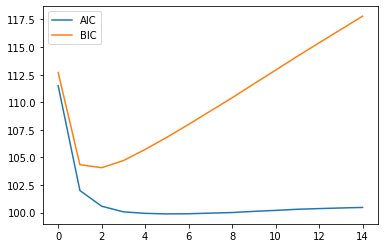

In [11]:
plt.plot(scores["AIC"], label = "AIC")
plt.plot(scores["BIC"], label = "BIC")
plt.legend()

### Validation croisée

In [12]:
n_knots = 10

for curr_p in tqdm(range(1,8)):
    cv_scores = pd.DataFrame({"Code station": liste_stations})
    
    for curr_split in range(9):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]

        spline_fit = fct_Modele_SplineGamma_fit(curr_train_X, liste_stations, n_knots)
        mesures_train_X_residus = fct_ModeleSplineGamme_residus(spline_fit, curr_train_X, liste_stations)
        model_VAR = VAR(mesures_train_X_residus[liste_stations])
        fit_VAR = model_VAR.fit(curr_p)

        # Prédictions
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_X_residus = fct_ModeleSplineGamme_residus(spline_fit, curr_test_X, liste_stations)
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        predictions_Y = fct_ModeleAR_predict(curr_test_X, fit_VAR, curr_p, liste_dates, liste_stations,
                                            spline_fit)
        
        # Score
        curr_scores = fct_scores_mse(curr_test_Y, predictions_Y, liste_stations)
        cv_scores["Split_" + str(curr_split)] = curr_scores["MSE"]

    cv_moyen = []
    for code in liste_stations:
        score = np.mean(cv_scores[cv_scores["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen.append(score)    
    cv_scores["Moyenne"] = cv_moyen
    cv_scores.to_csv("../Data/VAR/cv_p_" + str(curr_p).rjust(2, "0") + ".csv",
                     index=False)  

100%|██████████| 7/7 [08:01<00:00, 68.78s/it]


In [13]:
cv_moyen = pd.DataFrame()

# cv_Naif = pd.read_csv("../Data/Naif_Journalier/CV_scores.csv")
cv_Naif = pd.read_csv("../Data/GAM_Gamma_Journalier/cv_n_knots_10.csv")
curr_moyen = pd.DataFrame()
for code in liste_stations:
    curr_moyen[code] = list(cv_Naif[cv_Naif["Code station"] == code]["Moyenne"])
curr_moyen["Lag"] = 0
cv_moyen = pd.concat([cv_moyen, curr_moyen])

for curr_p in range(1, 8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/VAR/cv_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lag"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
cv_moyen.to_csv("../Data/VAR/cv_moyen.csv",
                index=False)

# Test

In [14]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

Cours eau  Index Couleur
0   Garonne      0     red
1     Loire      1   green
2     Seine      2    blue

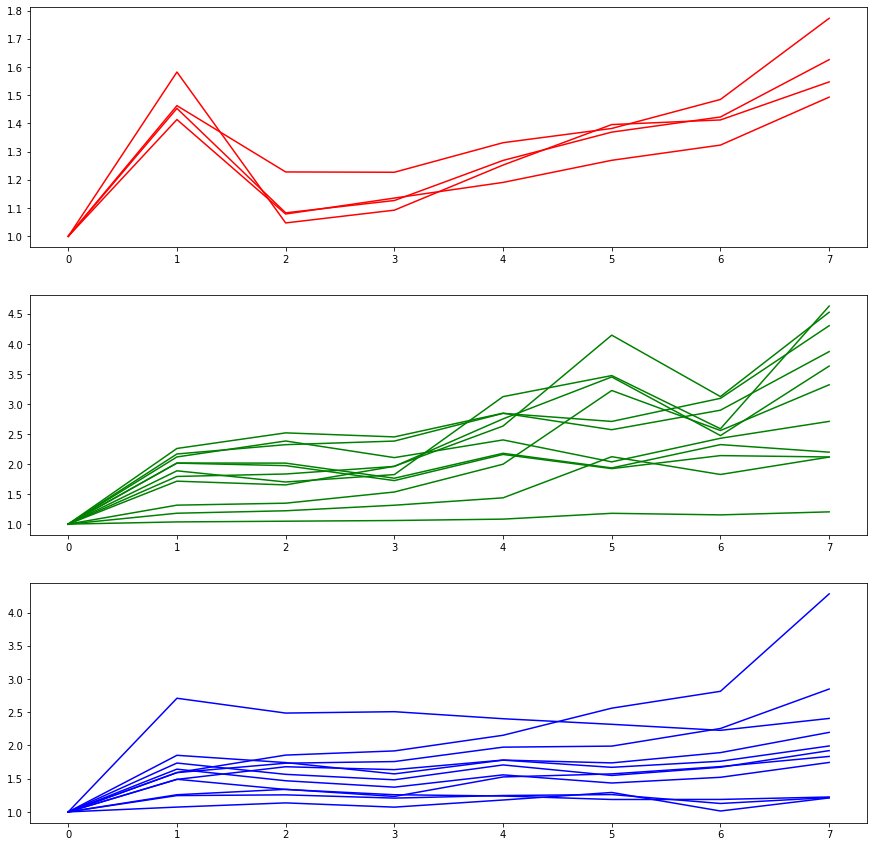

In [15]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,15))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lag"], cv_moyen[code]/cv_moyen[code].iloc[0],
                   color = cours_eau_cmap(i))
plt.show()

In [16]:
cv_moyen

O0200020      O2620010       O6140010       O9000010   K0030020  \
0  1818.417804  37178.637812   91881.726063  195086.959944  42.749790   
0  2660.560782  52566.093154  133537.673813  308676.772097  44.312375   
0  2233.324747  40118.942151   99531.692637  204344.118177  44.813497   
0  2231.265222  42217.887955  103539.837693  213175.520882  45.315100   
0  2421.773593  44281.873537  116590.312271  244359.962351  46.296637   
0  2513.637635  47195.939611  125815.587390  272357.035567  50.436415   
0  2700.583863  49201.132477  130740.674107  275558.461279  49.322981   
0  3223.506792  55518.491234  149411.503529  301844.006277  51.467376   

     K0100020     K0260020     K0550010     K0690010      K0910050  ...  \
0   97.454411   356.614547  1326.291598  1983.640321   3336.130474  ...   
0  115.105884   469.182573  2274.335978  3557.387061   6296.234301  ...   
0  119.098732   480.790224  2192.237912  3638.930566   5675.347515  ...   
0  128.102633   547.194085  2603.283301  3889.422749   6086.536435  ...   
0  140.083831   712.268419  3491.983689  5458.966338  10416.510666  ...   
0  206.835031  1149.932952  5498.493540  6843.311637  11585.891314  ...   
0  177.977019   912.234300  4141.874807  4907.170718   8630.901997  ...   
0  206.229582  1183.794132  6004.153554  7202.646145  15445.522143  ...   

      H0400010    H0400020    H0800011    H0800012     H0810010     H1700010  \
0   740.981486  429.226844  535.863833   67.224897   810.860041  3888.116318   
0  1103.691753  540.137484  574.692632  182.266996  1010.057650  5797.050950   
0  1244.802841  575.060491  608.505747  167.263017  1019.017148  5202.597036   
0  1212.382456  529.101072  574.253840  168.662317   979.386683  4893.456217   
0  1319.144086  655.158037  631.789512  161.536792  1010.887370  4818.183850   
0  1287.835021  674.798699  692.709312  155.877248  1022.542026  4614.696277   
0  1402.428892  722.072928  543.125379  149.795753   913.567356  4617.627565   
0  1628.219323  787.733803  648.580904  161.833170   985.722859  4760.999746   

       H3930020      H4340020       H8100021  Lag  
0  26587.092146  29262.966914   84106.635998    0  
0  46144.251107  48097.017308  155776.635055    1  
0  41622.146209  42988.748197  146560.742329    2  
0  39439.157029  40156.303777  132238.294794    3  
0  45388.350136  45581.427508  149668.183734    4  
0  41178.306799  41990.261311  140565.584498    5  
0  44462.647118  44508.159450  148258.096727    6  
0  51116.863665  51050.554115  167595.116874    7  

[8 rows x 27 columns]

In [17]:
p = 2

liste_dates = mesures_test_Y["Date"]
spline_fit = fct_Modele_SplineGamma_fit(mesures_test_X, liste_stations, n_knots)
mesures_test_X_residus = fct_ModeleSplineGamme_residus(spline_fit, mesures_test_X, liste_stations)

model_VAR = VAR(mesures_test_X_residus[liste_stations])
fit_VAR = model_VAR.fit(p)

predictions_test_Y = fct_ModeleAR_predict(mesures_test_X_residus, fit_VAR, p, liste_dates, liste_stations,
                                         spline_fit)
test_scores = fct_scores_mse(mesures_test_Y, predictions_test_Y, liste_stations)

In [18]:
test_scores.to_csv("../Data/VAR/Test_scores.csv",
                   index = False)

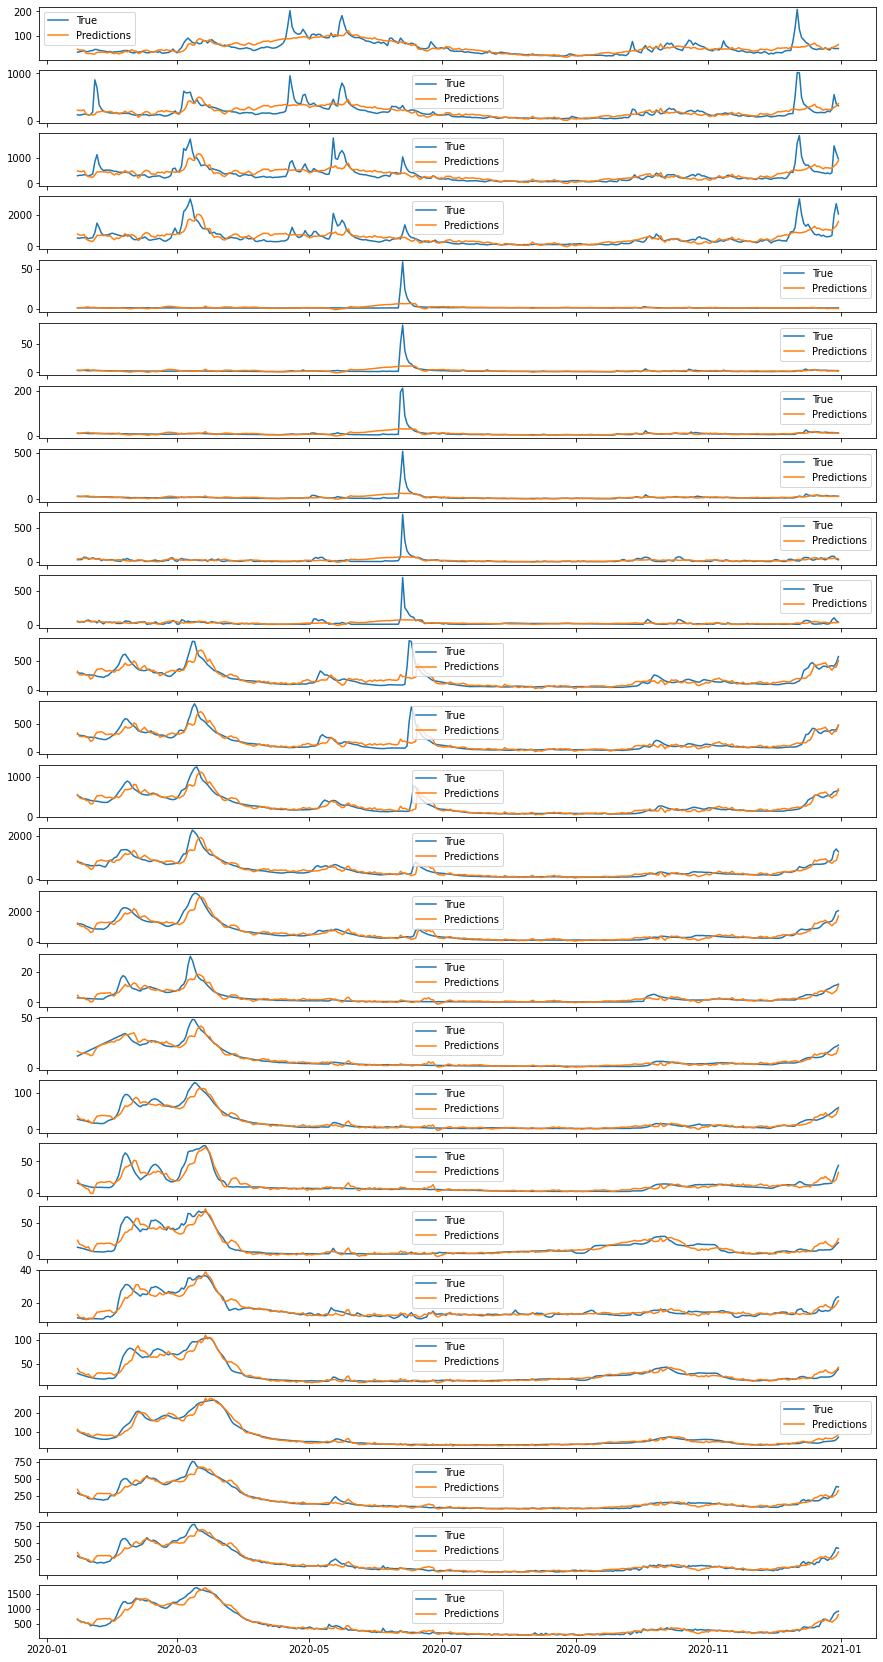

In [19]:
n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y["Date"], mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y["Date"], predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

In [20]:
test_scores

Code station            MSE
0      O0200020     336.252354
1      O2620010   14141.169806
2      O6140010   43822.391250
3      O9000010  104548.852276
4      K0030020      11.222032
5      K0100020      24.719507
6      K0260020     214.217182
7      K0550010     882.583385
8      K0690010    1609.724466
9      K0910050    1638.634928
10     K4180010    6734.981970
11     K4350020    5739.374049
12     K6830020    6910.196253
13     L8000020   18943.401260
14     M5300010   34893.613639
15     H0100010       3.466557
16     H0100020       5.742509
17     H0400010      54.727577
18     H0400020      30.221737
19     H0800011      32.670235
20     H0800012       3.972843
21     H0810010      40.220311
22     H1700010      98.036147
23     H3930020    1196.976410
24     H4340020    1490.859244
25     H8100021    5514.292699